<a href="https://colab.research.google.com/github/swan343/bin1/blob/main/Copy_of_cryoMaxLik2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[link text](https://)


Sophie Lohmann w/PCN 8/2019. Python 3.7.

make noisy dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ChineseLifeTilt85.tif [6 3 1] 1500 True
(85, 85)
check=1:  1.0000000000000002
noise 0
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
noise 1
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
noise 2
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


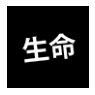

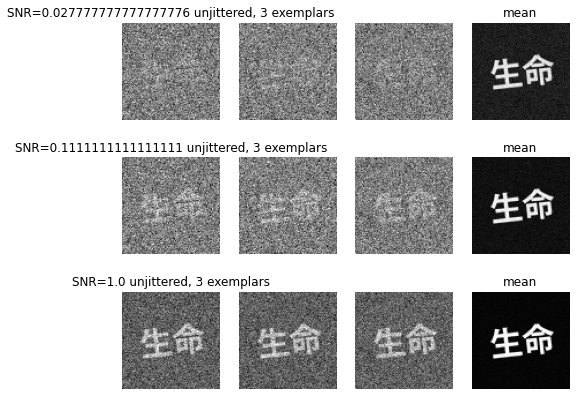

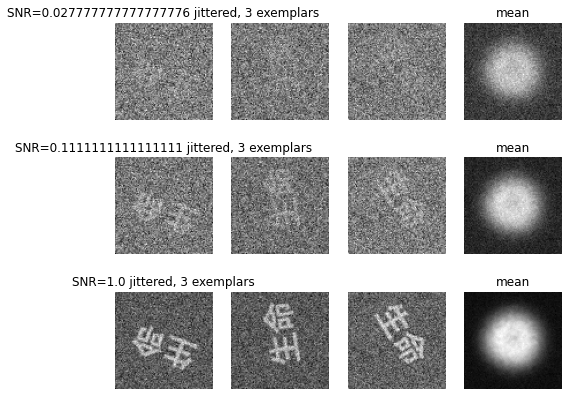

In [3]:
import scipy as sc
from scipy import ndimage
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from google.colab import drive


import numpy as np; import matplotlib.pyplot as plt
from numpy.random import randn, random
from scipy.ndimage.interpolation import rotate
from scipy.interpolate import griddata



plt.close('all')
siz = 85    # size of each 2D "image"
if siz%2==0: raise ValueError('siz should be odd')
Nsamp = 1500 # how many samples taken; =1500 in notes
shiftSD = 6 # how many pixels to jitter the fake data, normally 6
do_rotations = True  # False if you only want shifts (create image 2dNoisyJit)
    # True if you want shifts and rotations (create image 2dNoisyJitRot)
myImage = '/content/drive/MyDrive/ChineseLifeTilt85.tif' # alts 'ChineseLifeTilt85.tif' 'ChineseLife85.tif'; 'test2D.tif' 

drive.mount('/content/drive')
noiselevels = np.array([6, 3, 1]) # = 1/sqrt(SNR) because signal normalized to var=1; =[6, 3, 1] in notes
print(myImage, noiselevels, Nsamp, do_rotations)

def myimshow(y,ax):
    ax.imshow(y,'gray')
    ax.axis('off')

# get the "true image"
ys = plt.imread(myImage).astype('float')
print(ys.shape)
f,ax = plt.subplots(1,1,figsize=(1.5,1.5))
signalsig = np.var(ys)
ys = ys/np.sqrt(signalsig) # normalize to unit var
print('check=1: ', np.var(ys))
myimshow(ys,ax)
ys2 = ys.reshape((1,siz,siz))

noises = randn(Nsamp, siz, siz)
samples = np.zeros((Nsamp, siz, siz, 3))


# display a few examples of noisy data and show noise suppression by avg:
fig,ax = plt.subplots(3,4,figsize=(8,7),sharex=True, sharey=True)
for k in range(len(noiselevels)):
    noi = noiselevels[k]
    samples[:,:,:,k] = (ys2 + noi*noises) # sd of the noise is noiselevels[k]. broadcast ys.
    ax[k,0].set_title('SNR='+str(1/noiselevels[k]**2)+' unjittered, 3 exemplars')
    for which in [0,1,2]:
        myimshow(samples[which,:,:,k], ax[k,which])
    myimshow(np.mean(samples[:,:,:,k],axis=0), ax[k,3])
    ax[k,3].set_title('mean')


# now jitter the noisy data in x,y
jitters = randn(Nsamp,2)*shiftSD # translations
rotters = random(Nsamp)*2*np.pi  # rotations
buffers = int(2*(np.sqrt(2)-1)) + 4*shiftSD   # padding to make sure rotations fit
padsiz = siz + 2*buffers
xs = np.arange(siz)
xvals, yvals = np.meshgrid(xs, xs, indexing='ij')
padxs = np.arange(padsiz) - buffers
padxvals, padyvals = np.meshgrid(padxs, padxs, indexing='ij')
lpadxs = padxvals.ravel(); lpadys = padyvals.ravel() # linear listings
half = (siz-1)/2
paddedx = np.concatenate((np.zeros((buffers,siz)), ys, \
                         np.zeros((buffers,siz))), axis=0)
padded = np.concatenate((np.zeros((padsiz,buffers)), paddedx, \
                         np.zeros((padsiz,buffers))), axis=1)
for k in range(3):  # which noise level
    print('noise',k)
    for j in range(Nsamp):  # which image
        if j%100==0: print(j)
        angle = rotters[j]  # how much to rotate this instance
        if do_rotations:
            rotated = rotate(padded, angle*360/(2*np.pi), reshape=False)
        else:
            rotated = padded
        lpadded = rotated.ravel() # linear listing
        jitxvals = xvals + jitters[j,0]
        jityvals = yvals + jitters[j,1]
        samples[j,:,:,k] = noises[j,:,:]*noiselevels[k] + \
         griddata((lpadxs, lpadys), lpadded, (jitxvals.ravel(), jityvals.ravel()), \
         method='cubic', fill_value=0., rescale=False).reshape((siz,siz))
            

fig,ax = plt.subplots(3,4,figsize=(8,7), sharex=True, sharey=True)
for k in range(len(noiselevels)):
    noi = noiselevels[k]
    ax[k,0].set_title('SNR='+str(1/noiselevels[k]**2)+' jittered, 3 exemplars')
    for which in [0,1,2]:
        myimshow(samples[which,:,:,k], ax[k,which])
    myimshow(np.mean(samples[:,:,:,k],axis=0), ax[k,3])
    ax[k,3].set_title('mean')

np.savez('/content/drive/MyDrive/2dImages.npz',samples=samples,noiselevels=noiselevels,shiftSD=shiftSD,myImage=myImage)

load noisy dataset, ref image

In [1]:
import scipy as sc
from scipy import ndimage
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from google.colab import drive
drive.mount('/content/drive')
# Load data
x=np.load('/content/drive/MyDrive/2dImages.npz') #first version of dataset
#x=np.load('MBL/2dPrepChinese6-3-1-1500NewRotation.npz')
#x=np.load('MBL/2dImagesLOW.npz') #ultra-low SNR in first set, and 3000 images


# Extract variables
sd=x['shiftSD']
noiselevels = x['noiselevels']
smp = x['samples']
print(smp.shape); print(noiselevels)
# i think this dataset has been rotated by some random angle, shifted by max. 6 pixels? and applied noise;
# there are total 1500 imgs processed this way
# smp has the dimension format as 1500, 85, 85, 3: d
#1500 is total of noisy samples populated;
# 85 and 85 is the orig image dimension (the chinese char life's dimension), 85X85
# 3 is NOT RGB channels, but noise levels (6,3,1); higher noise level the noiser
# try plt.imshow(smp[0,:,:,1],'gray'), plt.imshow(smp[0,:,:,2],'gray') and plt.imshow(smp[0,:,:,0],'gray')
# reference image
ref = plt.imread('/content/drive/MyDrive/test2Dblur.png')
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
ref = rgb2gray(ref)

Mounted at /content/drive
(1500, 85, 85, 3)
[6 3 1]


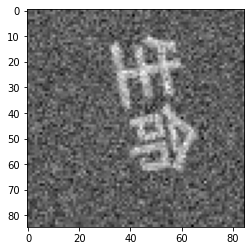

In [2]:
plt.imshow(smp[0,:,:,2],'gray')

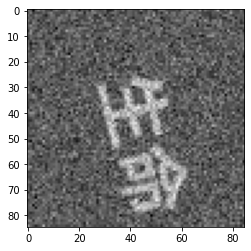

In [3]:
plt.imshow(smp[1,:,:,2],'gray')

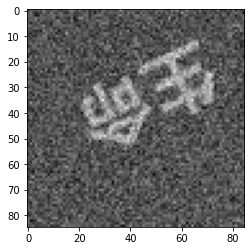

In [4]:
plt.imshow(smp[2,:,:,2],'gray')

showing the different noise levels of our dataset (we will use the noisiest level for the alignment process)




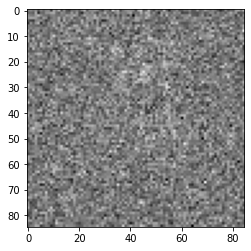

In [8]:
plt.imshow(smp[0,:,:,0],'gray')

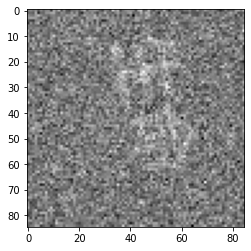

In [ ]:
plt.imshow(smp[0,:,:,1],'gray')

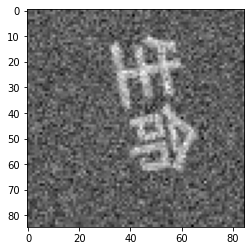

In [ ]:
plt.imshow(smp[0,:,:,2],'gray')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  if sys.path[0] == '':


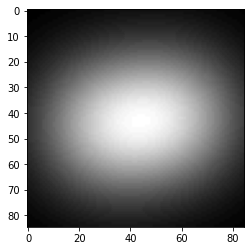

In [5]:
#create a reference

import cv2
from skimage.filters import threshold_otsu, gaussian


GAUSSIAN_FILTER_LEVEL = 18

denoised = cv2.imread('/content/drive/MyDrive/ChineseLifeTilt85.tif')
denoised = np.float32(denoised)
#denoised = cv2.cvtColor(denoised, cv2.COLOR_RGB2HSV)
denoised = gaussian(denoised, GAUSSIAN_FILTER_LEVEL)
cv2.imwrite('/content/drive/MyDrive/test2Dblur.png', denoised)

ref = plt.imread('/content/drive/MyDrive/test2Dblur.png')
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
ref = rgb2gray(ref)
plt.imshow(ref,'gray')

In [7]:
#rotate the reference image for alignment; only angles matter here

A = ref
sigma = 1
M = 85
s = 42
angles = 180
RA=np.array([ndimage.rotate(A,a*360/angles,reshape=False) for a in range(angles)])


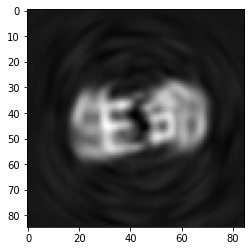

In [8]:
n = 0
X = smp[:,:,:,2]
exponent2=np.multiply(1/(np.square(sigma)), \
                [signal.correlate(RA[a,:,:], X[n,:,:], mode='same') for a in range(angles)])
#exponent1+
exponent=exponent2 # PN removed +exponent3

K=np.amax(exponent)

gammai=np.exp(exponent-K) #PN added +exponent3U=1/np.sum(gammai)
            
U=1/np.sum(gammai)

gammaXi=np.array([signal.convolve(X[n,:,:],gammai[a,:,:],mode='same') \
                  for a in range(angles)])

Apresum=U.reshape((1,1,1))*gammaXi 

A=np.zeros((M,M))

for a in range(angles):
    A+=ndimage.rotate(Apresum[a,:,:],(angles-a)*360/angles,reshape=False) 

plt.imshow(A, 'gray')

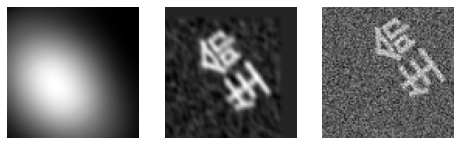

In [13]:
#take one piece of data (no noise for illustration, otherwise hard to see)

correlation_convolve_exp = smp[20,:,:,2]

def myimshow(y,ax):
    ax.imshow(y,'gray')
    ax.axis('off')

fig,ax = plt.subplots(1,3,figsize=(8,7), sharex=True, sharey=True)
#myimshow(ys,ax)

rotate_angle_num = 60
single_correlation = signal.correlate(RA[rotate_angle_num], correlation_convolve_exp, mode='same')
myimshow(single_correlation, ax[0])

K=np.amax(single_correlation)

gammai=np.exp(single_correlation-K)

myimshow(signal.convolve(correlation_convolve_exp,gammai,mode='same'), ax[1])
myimshow(correlation_convolve_exp, ax[2])

#left: correlated image(white = better correlation; start from the center, if white is upper-left, means 
#correlation is best when image is moved upper-left to match the reference)

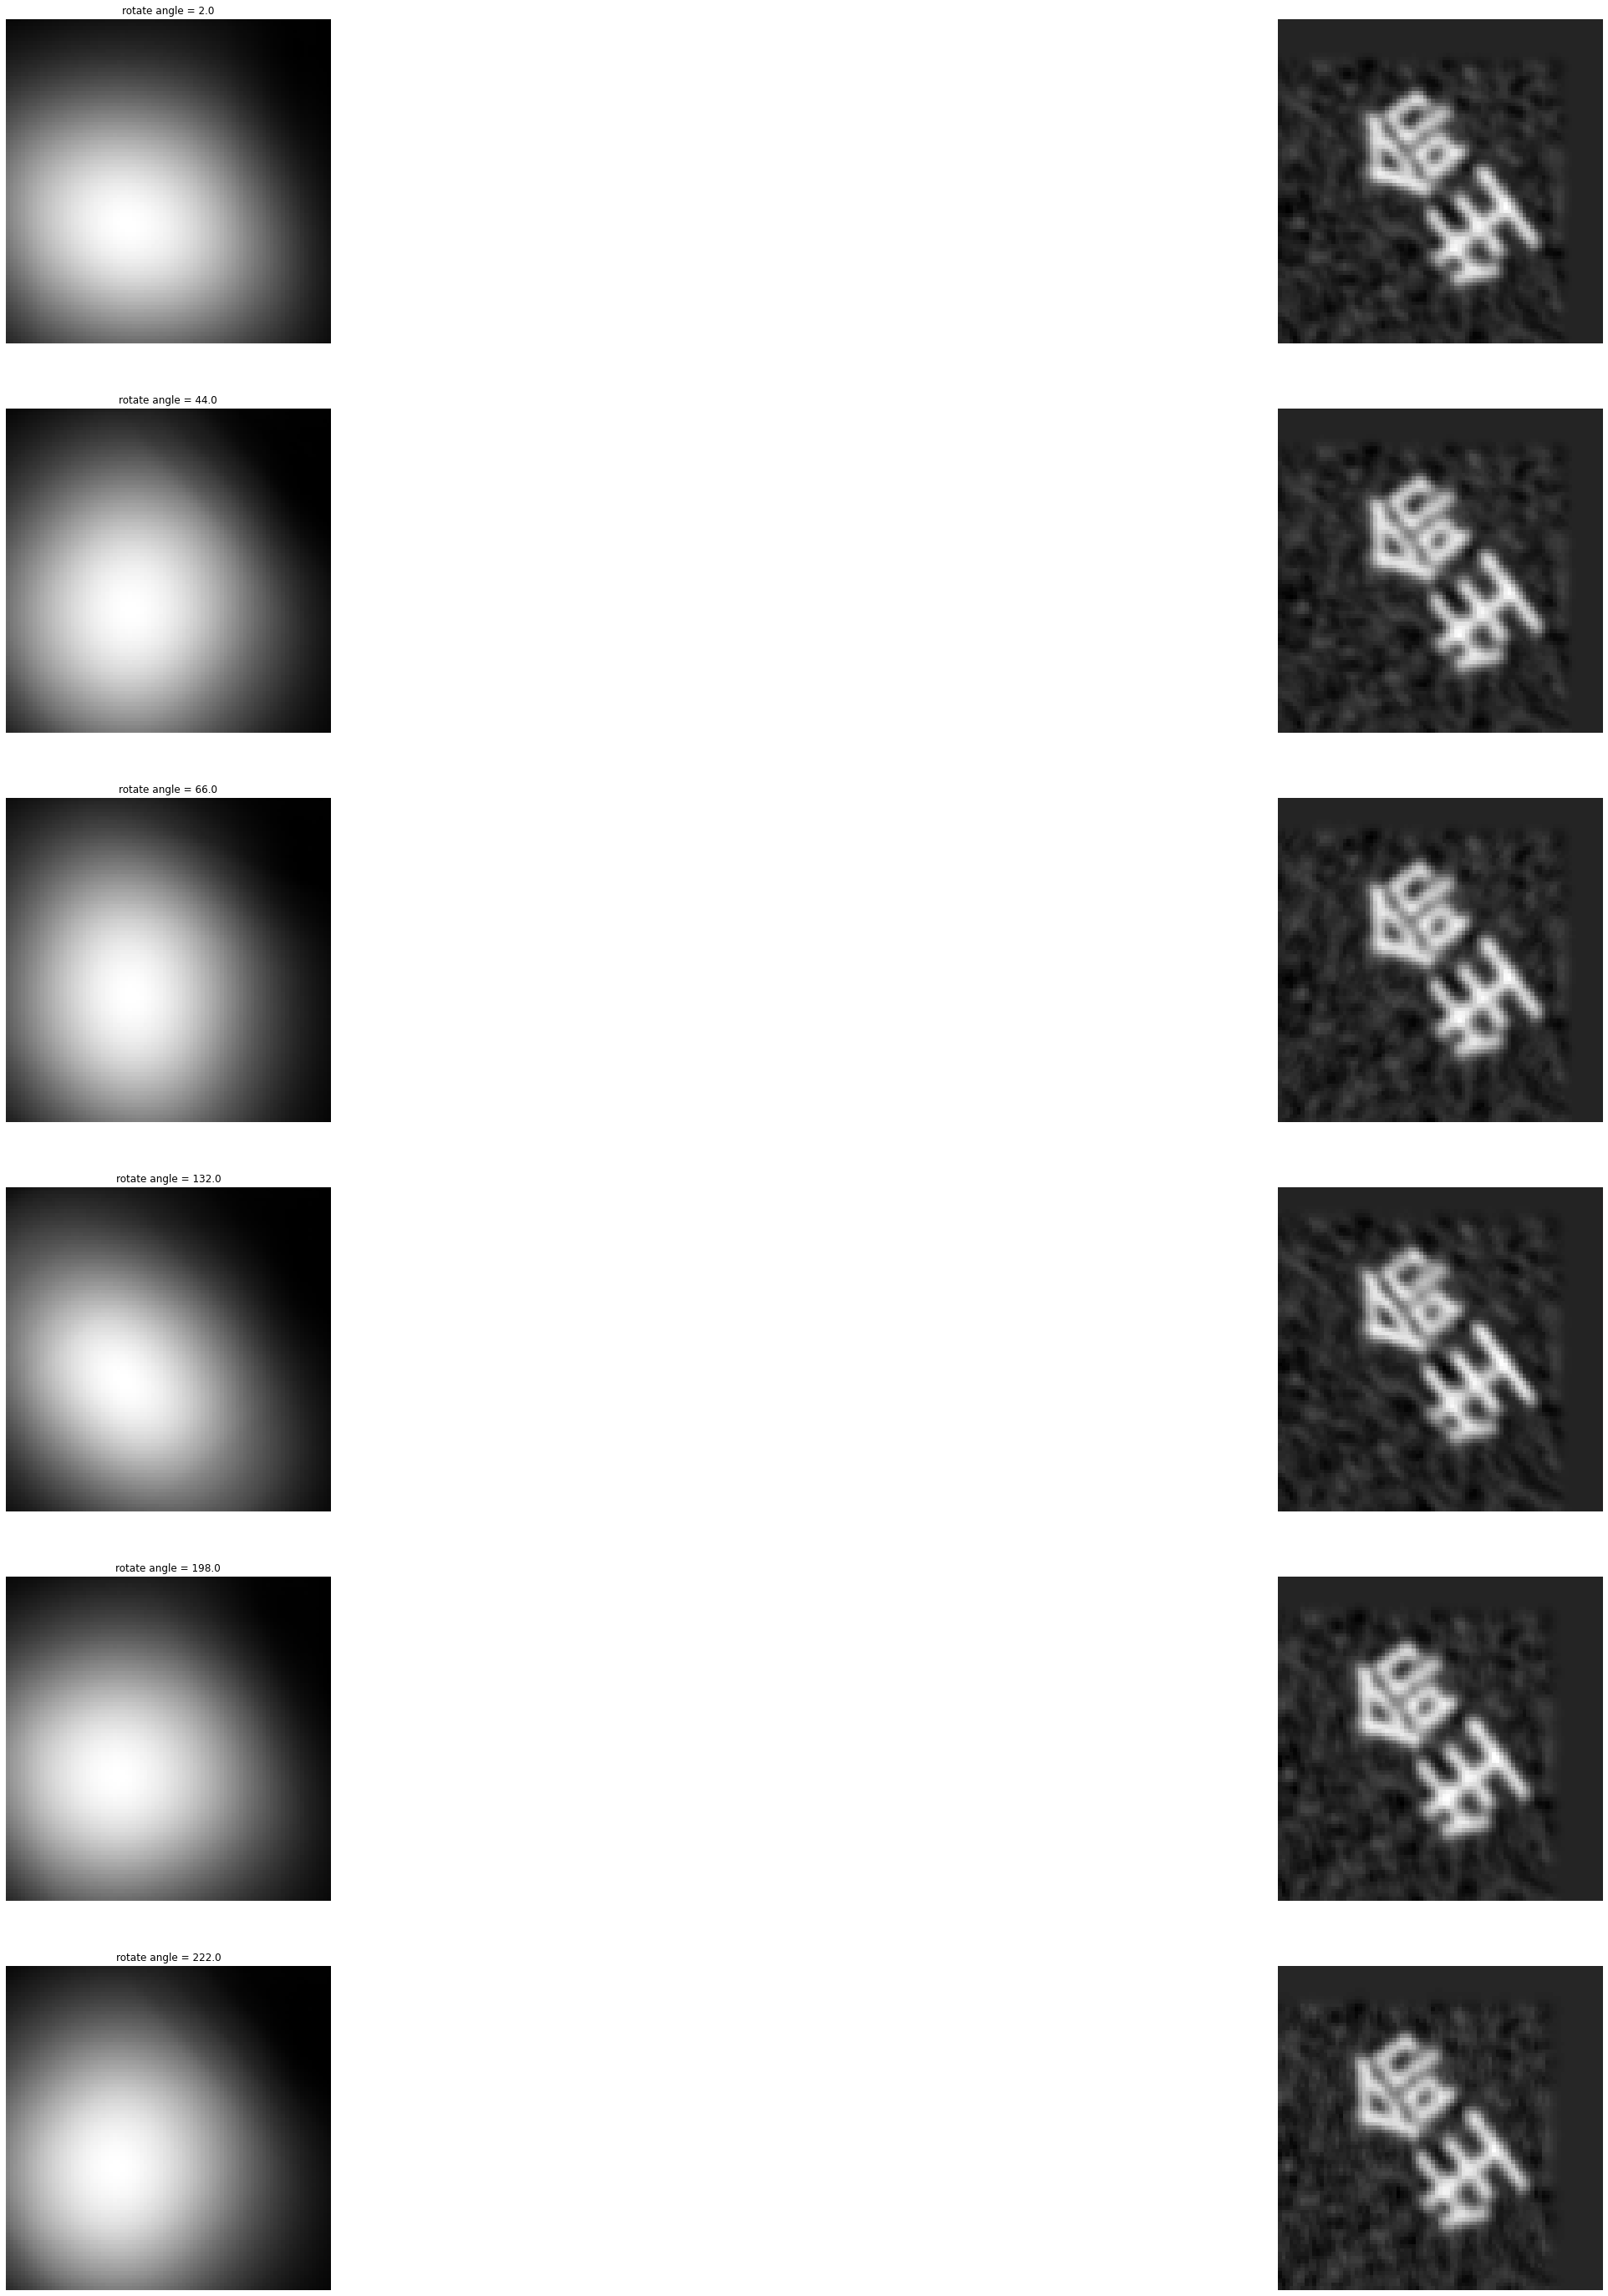

In [14]:
#if im comparing data to raotated ref 2deg, 44deg, 66deg, 132, etc...
#why r the convoluted images all look the same?

show_nums = [1, 22, 33, 66, 99, 111]
fig,ax = plt.subplots(len(show_nums),2,figsize=(50,50), sharex=True, sharey=True)

for i in range(len(show_nums)):
    rotate_angle_num = show_nums[i]
    single_correlation = signal.correlate(RA[rotate_angle_num], correlation_convolve_exp, mode='same')
    ax[i,0].set_title('rotate angle = ' + str(360 / angles * show_nums[i]))
    myimshow(single_correlation, ax[i][0])

    K=np.amax(single_correlation)

    gammai=np.exp(single_correlation-K)

    myimshow(signal.convolve(correlation_convolve_exp,gammai,mode='same'), ax[i][1])

In [15]:
#correlate measures how well an image "aligns" to the other; the magnitude of 
#correlation is different for the data correlating against many rotated forms of the 
#reference


exponent2 = [signal.correlate(RA[a,:,:], correlation_convolve_exp, mode='same') for a in range(angles)]

K=np.amax(exponent2)

gammai=np.exp(exponent2-K)

print([round(np.sum(gammai[i]),2) for i in range(angles)])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.03, 0.08, 0.18, 0.38, 0.78, 1.47, 2.6, 4.14, 5.99, 7.49, 9.11, 9.78, 10.06, 8.86, 7.13, 4.85, 3.38, 2.12, 1.19, 0.68, 0.33, 0.16, 0.06, 0.03, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.04, 0.09, 0.22, 0.48, 0.99, 1.77, 2.83, 4.18, 5.8, 7.35, 8.7, 9.29, 9.35, 8.63, 7.18, 5.58, 3.68, 2.41, 1.28, 0.7, 0.31, 0.15, 0.06, 0.02, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


total # of noisy imgs: 1500
iteration # 0
iteration # 1
iteration # 2
iteration # 3
iteration # 4
iteration # 5
time:  753.343926987


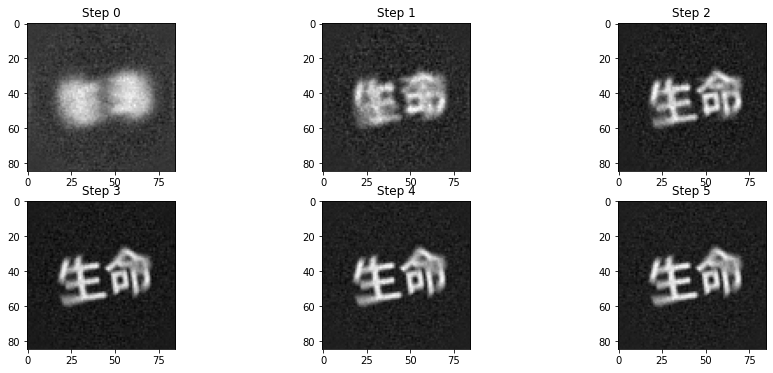

In [2]:
def maxlikelihood2d(X,A,sigma,sigmaq,Nsteps=3,xiq0=0,xiq1=0,angles=30):
  #X is the 
    N=X[:,0,0].size
    #N=100 # for debugging
    print('total # of noisy imgs:',N)
    start=timer()
    M=X[0,0,:].size # ref minage's X,Y size, this case 85
    # i guess s is the stepping size (how mcuh the particle can move);
    # due to our box size to particle here (characters Y height is about half of the entire image)
    # s needs to be half of M.
    s=int((M-1)/2)
    
    fig, axs = plt.subplots(int((Nsteps-1)/3)+1,3, figsize=(15, 6))
    axs = axs.ravel()
    
    for ns in range(Nsteps): 
        print('iteration #', ns)
        Apresum=np.zeros((angles,M,M)) # PN
        #reference img (A) is rotated by 360/60 degs, or 6 deg per rotation, and total of 60 rotations as a samplling method;
        #this ends up with 60X of image A (60,85,85?) 
        #ovbiously more angles to sample = more time spent in alignment = better alignment, less angle = worse
        RA=np.array([ndimage.rotate(A,a*360/angles,reshape=False) for a in range(angles)])
        
        for n in range(N):         
            exponent2=np.multiply(1/(np.square(sigma)), \
                [signal.correlate(RA[a,:,:], X[n,:,:], mode='same') for a in range(angles)])
        
            exponent=exponent2 # PN removed +exponent3
        
            K=np.amax(exponent)
        
            gammai=np.exp(exponent-K)#+exponent3) #PN added +exponent3
        
            U=1/np.sum(gammai)
            
            gammaXi=np.array([signal.convolve(X[n,:,:],gammai[a,:,:],mode='same') \
                              for a in range(angles)])
            Apresum+=U.reshape((1,1,1))*gammaXi
        
        A=np.zeros((M,M))
        
        for a in range(angles):
            A+=1/N*ndimage.rotate(Apresum[a,:,:],(angles-a)*360/angles,reshape=False) 
        
        axs[ns].imshow(A,'gray')
        
        axs[ns].set_title('Step {}'.format(ns))
    print('time: ',timer()-start)
    return A

#to get thing started we use the highest noise levle (6), or smp[:,:,:,0] 
qq=0; A=maxlikelihood2d(smp[:,:,:,qq],ref,sigma=0.2,sigmaq=0.2,Nsteps=6, angles =24)

#plt.imsave('out'+str(qq)+'.pdf', A, cmap='gray')